In [1]:
import numpy as np
import seaborn as sns;
from matplotlib import pyplot as plt
import itertools

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from sklearn.ensemble import RandomForestClassifier

In [2]:
cd /Users/William/Documents/GitHub/progressive-learning

/Users/William/Documents/GitHub/progressive-learning


In [3]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

Using TensorFlow backend.


In [4]:
from sklearn.datasets import make_blobs

def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, angle_params=None, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [5]:
def make_meshgrid(X, range_function='arange', step_size=0.1, num_step=30, padding=1):
    
    dims = []
    
    for n in range(X[0].size):
        x_min = X[:,n].min()-padding 
        x_max = X[:,n].max()+padding
        
        if range_function == 'linspace':
            dims.append(np.linspace(x_min, x_max, num_step))
        else:
            dims.append(np.arange(x_min, x_max, step_size))
        
    mesh = np.meshgrid(*dims)
    grid = np.array([m.ravel() for m in mesh]).T
    
    return grid

# Experiment 1 
Mapping XOR to N_XOR

In [6]:
#Parameters
h = 0.1
g = 50

#Make XOR1 and XOR2
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/2)

#Grid Setup for XOR1
G1 = make_meshgrid(X1, range_function='linspace', step_size=h, num_step=g)
G2 = make_meshgrid(X2, range_function='linspace', step_size=h, num_step=g)

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,y1).predict_proba(G1)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,y2).predict_proba(G2)

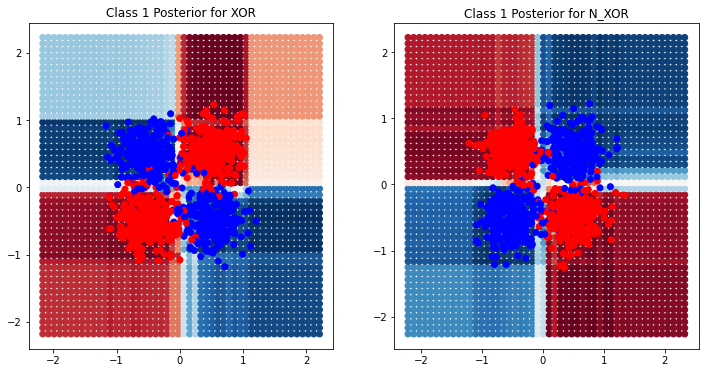

In [7]:
#Plot class 1 posterior for XOR
plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='bwr') 
plt.title('Class 1 Posterior for XOR');

#Plot class 1 posterior for N_XOR
plt.subplot(122)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr') 
plt.title('Class 1 Posterior for N_XOR');

In [8]:
#Registration
template = np.c_[G1,ZZ1[:,0]]
target = np.c_[G2,ZZ2[:,0]]

df_reg = DeformableRegistration(X=target, Y=template, max_iterations=20)
deformed_template = df_reg.register(template)

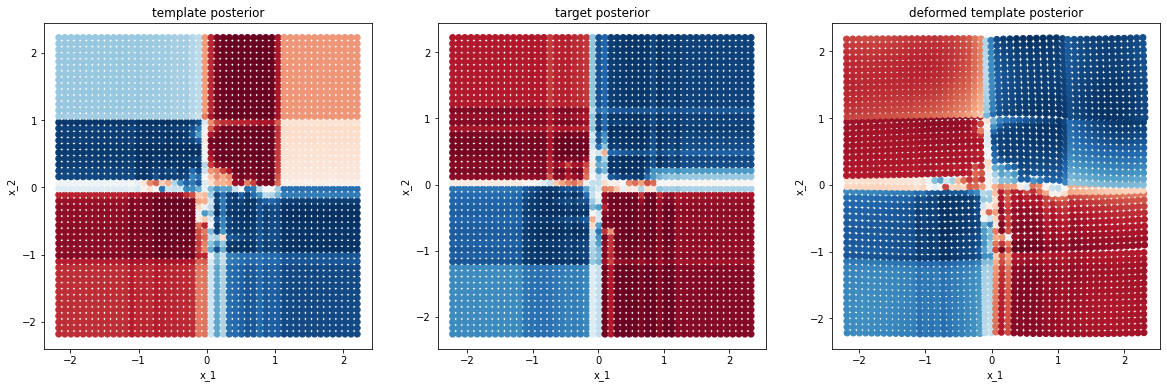

In [9]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.title("template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");


plt.subplot(132)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.title("target posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

z = deformed_template[0]

plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2], cmap='RdBu')
plt.title("deformed template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

# Experiment 2
Mapping XOR to R_XOR

In [10]:
#Parameters
h = 0.1
g = 50

#Make XOR1 and XOR2
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, angle_params=np.pi/3)

#Grid Setup for XOR1
G1 = make_meshgrid(X1, range_function='linspace', step_size=h, num_step=g)
G2 = make_meshgrid(X2, range_function='linspace', step_size=h, num_step=g)

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,y1).predict_proba(G1)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,y2).predict_proba(G2)

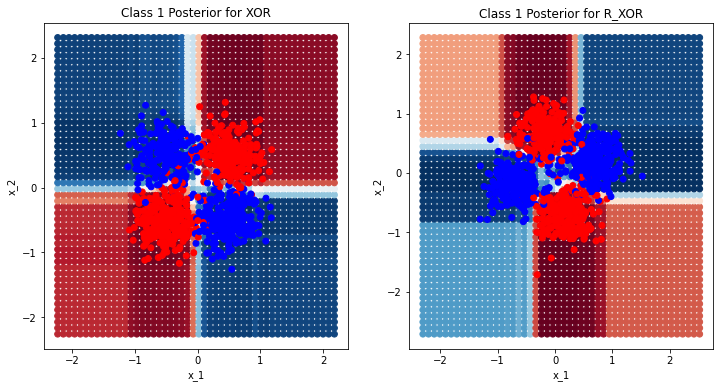

In [11]:
#Plot class 1 posterior for XOR
plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='bwr')  
plt.title('Class 1 Posterior for XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

#Plot class 1 posterior for R_XOR
plt.subplot(122)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr') 
plt.title('Class 1 Posterior for R_XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

In [12]:
#Registration
template = np.c_[G1,ZZ1[:,0]]
target = np.c_[G2,ZZ2[:,0]]

df_reg = DeformableRegistration(X=target, Y=template, max_iterations=15)
deformed_template = df_reg.register(template)

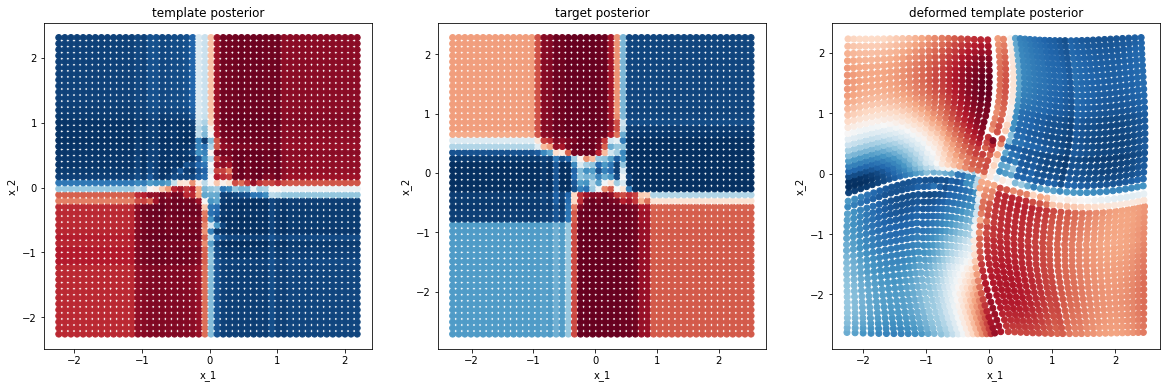

In [13]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.title("template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

plt.subplot(132)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.title("target posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

z = deformed_template[0]

plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2], cmap='RdBu')
plt.title("deformed template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

# Experiment 3
Mapping XOR to translated  and expanded R_XOR

In [14]:
#Parameters
h = 0.1
g = 50
c = [(-1, 1), (1, 1), (-1, -1), (1, -1)]

#Make XOR1 and XOR2
X1, y1 = generate_gaussian_parity(n_samples=1000)
X2, y2 = generate_gaussian_parity(n_samples=1000, centers=c, angle_params=np.pi/3)
X2 = X2 + 10

#Grid Setup for XOR1
G1 = make_meshgrid(X1, range_function='linspace', step_size=h, num_step=g)
G2 = make_meshgrid(X2, range_function='linspace', step_size=h, num_step=g)

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,y1).predict_proba(G1)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,y2).predict_proba(G2)

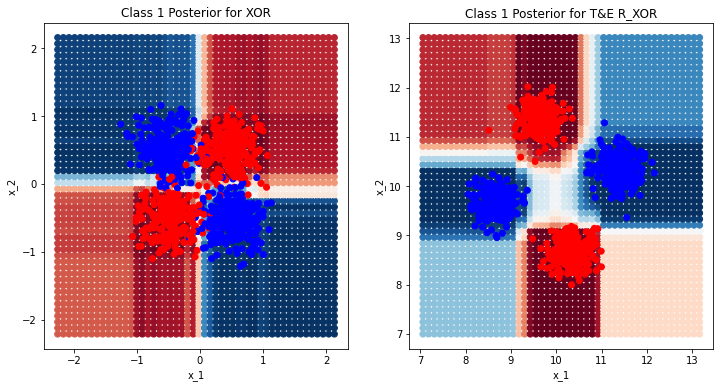

In [15]:
#Plot class 1 posterior for XOR1
plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='bwr')  
plt.title('Class 1 Posterior for XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

#Plot class 1 posterior for XOR2
plt.subplot(122)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr') 
plt.title('Class 1 Posterior for T&E R_XOR');
plt.xlabel("x_1"); plt.ylabel("x_2");

In [16]:
#Registration
template = np.c_[G1,ZZ1[:,0]]
target = np.c_[G2,ZZ2[:,0]]

df_reg = DeformableRegistration(X=target, Y=template, max_iterations=20)
deformed_template = df_reg.register(template)

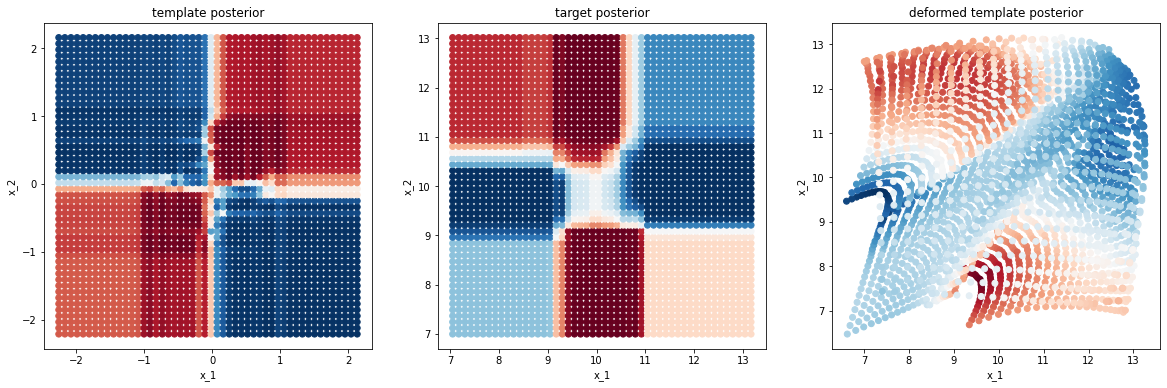

In [17]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0], cmap='RdBu')
plt.title("template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

plt.subplot(132)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0], cmap='RdBu')
plt.title("target posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

z = deformed_template[0]

plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2], cmap='RdBu')
plt.title("deformed template posterior")
plt.xlabel("x_1"); plt.ylabel("x_2");

# Experiment 4

Use voters/deciders to merge two posteriors?